# RSA efficiency theorem (step 0..)

***Efficient communication from pragmatics when uncertainty.***

### Setup

```
L = Lexicon ('b', 'g', 's', 'c', 'd', 't')  # blue, green, square, circle, 'dashed', 'doTTed'
u in L = utterance from L (e.g. 'b')        # blue
C = context (e.g. 'bsd', 'gcd', 'bct')         # blue-square-dashed, green-circle-dashed, blue-circle-dotted
r in C = referrent in context (e.g. blue-square)
D = dimensions = L
d in D = dimension in Dimensions (e.g. 'b')
p(d) = dimension probability, ratio of items which contain dimension d
BR(L|C) = bit rate
CE(C) = context entropy
CL(C) = # of clusters in C
```
$$BR(L|C)= \frac{1}{|L|}\sum_{u \in L}-log(\frac{|[\![u]\!]|}{|C|})$$
$$p(d) = \frac{1}{|D|}\sum_{r \in C}\delta(d, r)$$
$$CE(C)= -\sum_{d \in D}p(d)\times log(p(d))$$
$$CL(C)= \text{length}(set(C)))$$

###  Step 0
The bit rate of a language $L$ (code) used in context $C$ for a pragmatic speaker $L_{S1}$ is at least as great as the bit rate of an S0 language $L_{S0}$ speaker.

$$BR(L_{S_1}) \ge BR(L_{S_0})$$

For $CE(C) > 1.$, this inequality is strict. That is, as long as there is at least one dimension $d$ along which a single referent $r \in C$ differs, a pragmatic speaker can make efficient use of that dimension.

$$BR(L_{S_1}) > BR(L_{S_0}) \iff CE(C) > 1.$$


In [25]:
from collections import Counter
import itertools as it
import math
import numpy as np
import pandas as pd
import seaborn as sns

Simulation setup.

In [26]:
context_size = 4  # number of possible referrents
n_dimensions = 3
color = ['b', 'g']
shape = ['s', 'c']
texture = ['d', 't']
us = color + shape + texture
pairs = ['{}{}{}'.format(c, s, t) for c in color for s in shape for t in texture]
contexts = list(it.product(pairs, repeat=4))
len(contexts)
assert len(contexts) == (len(color)*len(shape)*len(texture))**context_size
# n_dimensions((n_dimensions*len(color))**len(color))**context_size)

Helpers.

In [27]:
def create_L0_matrix(context):
    """Generate L0 literal matrix."""
    M = []
    for c in context:
        r = [u in c for u in us]
        M.append(r)
    M = np.array(M).reshape(len(context), len(us)).astype(float)
    return M

def L(M):
    """Listener"""
    return S(M.transpose()).transpose()

def S(M, do_round=False):
    """Speaker"""
    norm = np.sum(M, axis=0)
    res = np.nan_to_num(M / norm)
    if do_round:
        res_t = res.T
        for col, _ in enumerate(res_t):
            col_max = np.max(res_t[col, :])
            for row, _ in enumerate(res_t[col, :]):
                if res_t[col, row] != 0 and res_t[col, row] == col_max:
                    res_t[col, row] = 1.
                else:
                    res_t[col, row] = 0.
        res = res_t.T
    return res
# context_1 = ('bsd', 'bsd', 'bcd', 'bcd')
# print(S(L(S(create_L0_matrix(context_1))), True))

def fill_w_L0(M, L0):
    """Back-off to literal instantiation."""
    empty_rows = [i for i, v in enumerate(np.sum(M, axis=1)) if v == 0]
    for r in empty_rows:
        for j, c in enumerate(M[r, :]):
            M[r, j] = L0[r, j] if np.sum(M[r, :]) == 0 else M[r, j]
    return M

def m2code(M, context):
    """Convert matrix to code."""
    us = ['b', 'g', 's', 'c', 'd', 't']
    V = []
    for i, c in enumerate(context):
        V.append([us[k] for k, j in enumerate(M[i]) if j == 1])
    return V

def entropy(x):
    """Entropy calculation."""
    return -np.sum([i * np.log2(i) for i in x])

def context_entropy(context):
    """Context entropy."""
    cnts = np.array(Counter(''.join(context)).values()).astype(float)
    total = np.sum(cnts)
    ps = cnts / total
    ent = entropy(ps)
    return ent

def get_bit_rate(m):
    """Utterance bit rate."""
    res = []
    for col in m.T:
        s = float(np.sum(col))/len(m[0,:])
        log_s = -np.log2(s) if s != 0 else 0.
        res.append(log_s)  
    return np.mean(res)
# context_1 = ('bsd', 'bsd', 'bsd', 'bsd')
# get_bit_rate(S(L(S(create_L0_matrix(context_1))), True))

Get data.

In [28]:
data = []
for c in contexts:
    m_L0 = create_L0_matrix(c)
    m_S0 = m_L0
    m_S1 = fill_w_L0(S(L(S(m_L0)), True), m_L0)  # If no pragmatics, back-off to literal
    res = {
        'unique_groups': len(Counter(c).keys()),
        'context': ' '.join(c),
        'context_entropy': context_entropy(c),
        'S0_bit_rate': get_bit_rate(m_S0),
        'S1_bit_rate': get_bit_rate(m_S1)
    }
    data.append(res)
df = pd.DataFrame(data)

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


In [29]:
df_melt = df \
    .melt(id_vars=['context', 'context_entropy', 'unique_groups'], value_vars=['S0_bit_rate', 'S1_bit_rate'],
          value_name='bit_rate')
df_melt['context_entropy'] = df_melt['context_entropy'].apply(lambda x: round(x, 3))
df_melt['bit_rate'] = df_melt['bit_rate'].apply(lambda x: round(x, 3))

Plotting.

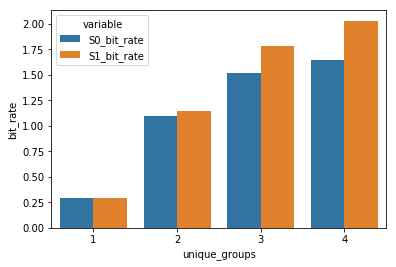

In [30]:
sns.barplot(x='unique_groups', y='bit_rate', hue='variable',ci=None, data=df_melt)

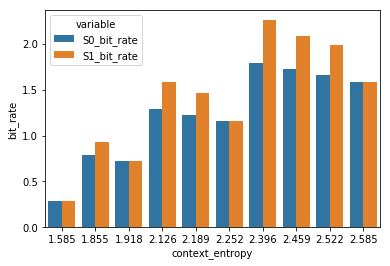

In [32]:
sns.barplot(x='context_entropy', y='bit_rate', hue='variable', ci=None, data=df_melt)

This plot says that for every possible communicative context $c \in C$ the average utterance informativity for a pragmatic speaker is great than for a literal speaker as long as the context support any pragmatic enrichment (context entropy > 1).

Note that the points in which `S0==S1` are cases in which there is no pragmatic information.

In [24]:
df_melt[df_melt['context_entropy'].isin([1.918, 2.252, 2.585])].head()

,context,context_entropy,unique_groups,variable,bit_rate
9,bsd bsd bst bst,1.918,2,S0_bit_rate,0.723
18,bsd bsd bcd bcd,1.918,2,S0_bit_rate,0.723
27,bsd bsd bct bct,2.252,2,S0_bit_rate,1.154
36,bsd bsd gsd gsd,1.918,2,S0_bit_rate,0.723
45,bsd bsd gst gst,2.252,2,S0_bit_rate,1.154


# Old

In [8]:
# data = []
# for c in contexts:
#     L0 = create_L0_matrix(c)
#     S0_code = m2code(L0, c)
#     S1_m = fill_w_L0(S(L(S(L0)), True), L0)  # If no pragmatics, back-off to literal
#     S1_code = m2code(S1_m, c)
#     res = {
#         'S0_1': ''.join(S0_code[0]),
#         'S0_2': ''.join(S0_code[1]),
#         'S0_3': ''.join(S0_code[2]),
#         'S1_1': ''.join(S1_code[0]),
#         'S1_2': ''.join(S1_code[1]),
#         'S1_3': ''.join(S1_code[2]),
#         'context': ' '.join(c)
#     }
#     data.append(res)

In [9]:
# df = pd.DataFrame(data); df.head()

In [10]:
# df["S0_length"] = df.apply(lambda x: len(x["S0_1"]) + len(x["S0_2"]) + len(x["S0_3"]), axis=1)
# df["S1_length"] = df.apply(lambda x: len(x["S1_1"]) + len(x["S1_2"]) + len(x["S1_3"]), axis=1)

In [11]:
# df_melt = df \
#     .melt(id_vars=['context'], value_vars=['S0_1', 'S0_2', 'S0_3', 'S1_1', 'S1_2', 'S1_3'],
#           value_name='code')
# df_melt['level'] = df_melt.apply(lambda x: 'S1' if 'S1' in x['variable'] else 'S0', axis=1)
# df_melt['bits'] = df_melt.apply(lambda x: len(x['code']), axis=1)
# # Filter to S1
# df_melt = df_melt[df_melt['level'] == 'S1']
# df_melt['context_entropy'] = df_melt.apply(lambda x: context_entropy(x['context'].split()), axis=1)

In [9]:
# df_melt_prag = df_melt[df_melt['context_entropy'] > 1.5]

In [10]:
# float(df_melt_prag['bits'].sum()) / len(df_melt_prag)

In [11]:
x_1 = [float(1)/3, float(1)/3, float(2)/3]
x_2 = [float(3)/3, float(3)/3]

In [12]:
np.mean(map(lambda j: -np.log2(j), x_2))

0.0

In [13]:
S(L(S(create_L0_matrix(context_1))), True)

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


array([[1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [14]:
context_0 = ('bs', 'gs', 'bc')
context_1 = ('bs', 'bs', 'bc')
context_2 = ('bs', 'bs', 'bs')

In [15]:
m0 = create_L0_matrix(context_1)
m1 = S(L(S(create_L0_matrix(context_1))), True)
print(m0)
print(m1)

[[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 0. 1.]]
[[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [0. 0. 0. 1.]]


/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
